# The Continuous Thought Machine – Tutorial 03: Mazes [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SakanaAI/continuous-thought-machines/blob/main/examples/01_mnist.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

### Maze Solving

In Section 4 of the [technical report](https://arxiv.org/pdf/2505.05522), we showcase how a CTM can be used to solve 2D mazes. Typically in the literature, the task of solving a maze is described as a form of binary classification: by ensuring the output space matches the dimensions of the input space, a model can classify, for each pixel in the input image, if the pixel belongs to the path though the maze. While this approach has seen success, it exludes the need to think in a more natural fashion. We seek to design a more challening task, where a more-human like solution is required.



### Solving Mazes the Hard Way

Instead of classifying if each pixel in the maze is or is not along the solution path, we instead constrain the output space, such that the model must output a plan: an entire trajectory of actions corresponding to the steps an agent must take to go from the start position to goal position. Specifically, for each internal tick of the CTM, the model produces a sequence of actions. These actions correspond to Left, Right, Up, Down and Wait (or no-op). We can then use a cross-entropy loss function which compares these actions produced by the CTM to the ground-truth trajectory required to solve the maze.

### Tutorial Overview

This tutorial will walk through how to train a CTM to solve mazes the hard way. It is structured as follows:
1) Setup
2) Data
3) Loss Function
4) Writing a Training Function
5) Creating the CTM
6) Running the Training

### Setup

In addition to installing some dependencies, we also clone the CTM repo (assuming this tutorial is being ran in Colab), so that we can access the base CTM model.

In [1]:
!pip install gdown
!pip install mediapy
!git clone https://github.com/SakanaAI/continuous-thought-machines.git


^C
ERROR: Operation cancelled by user
fatal: destination path 'continuous-thought-machines' already exists and is not an empty directory.


Download the training and test data

In [ ]:
!gdown "https://drive.google.com/uc?id=1Z8FFnZ7pZcu7DfoSyfy-ghWa08lgYl1V"
!unzip "small-mazes.zip"

Imports

In [47]:
%matplotlib inline
import sys
sys.path.append("./continuous-thought-machines")

import os
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# From CTM repo
from models.ctm import ContinuousThoughtMachine as CTM
from data.custom_datasets import MazeImageFolder
from tasks.mazes.plotting import make_maze_gif
from tasks.image_classification.plotting import plot_neural_dynamics

### Data

The training (test) folder contains roughly 9000 (1000) images of mazes, at a resolution of 15x15. In these images, the red and green pixels correspond to the start and goal position respectively, while the blue pixels indicate the path through the maze. We will use these blue pixels to construct targets, and remove them from the images.

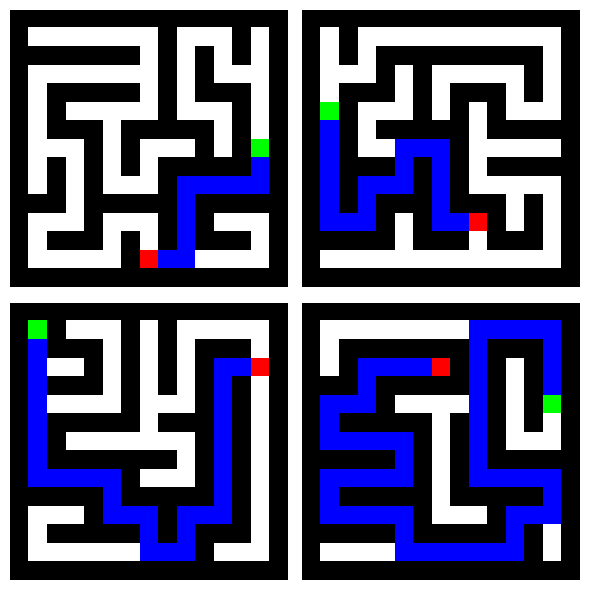

In [ ]:
data_root = './small-mazes'
train_dir = f"{data_root}/train/0"
images = os.listdir(train_dir)[:4]

plt.figure(figsize=(6, 6))
for i, img_name in enumerate(images):
    img = Image.open(f"{data_root}/train/0/{img_name}")
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

To use these mazes, we have built a custom dataset `MazeImageFolder`. This dataset creates the input-target pairs corresponding to the unsolved mazes images and their solutions. For more details on how this dataset process the images, please refer to it's implementation [here](https://github.com/SakanaAI/continuous-thought-machines/blob/aecfb63ac42db7a20903ee27489ff71671669474/data/custom_datasets.py#L142C7-L142C22).

Note that the `MazeImageFolder` takes a `maze_route_length` argument. This parameter specifies the fixed length of action sequences that the CTM will generate at each internal tick. Since different mazes have solutions of varying lengths, all target sequences are padded with the wait action (integer 4) to ensure they match the specified `maze_route_length`.

In [50]:
train_data = MazeImageFolder(root=f'{data_root}/train/', which_set='train', maze_route_length=50)
test_data = MazeImageFolder(root=f'{data_root}/test/', which_set='test', maze_route_length=50)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=1, drop_last=False)

Loading mazes:   1%|          | 85/9000 [00:00<00:18, 476.13it/s]

Loading mazes: 100%|██████████| 9000/9000 [00:20<00:00, 439.41it/s]


Solving all mazes...


Loading mazes: 100%|██████████| 1000/1000 [00:02<00:00, 494.09it/s]


Solving all mazes...


We can visualise what these inputs and targets look like.

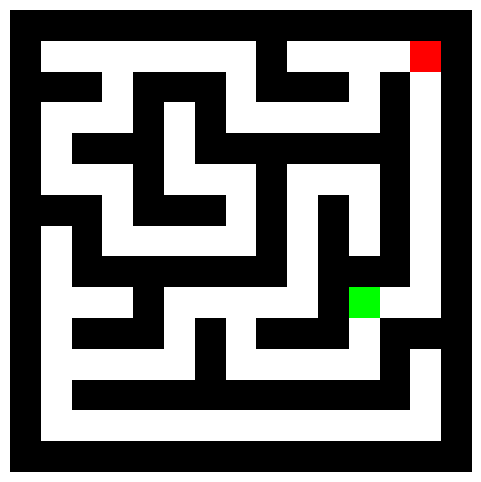

Target action sequence:
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [51]:
sample_inputs, sample_targets = next(iter(testloader))
sample_input, sample_target = sample_inputs[0], sample_targets[0]
sample_input = sample_input.permute(1, 2, 0).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(sample_input, 0, 1))
plt.axis('off')
plt.show()

print("Target action sequence:")
print(f"{sample_target.tolist()}")

As shown in the above output, the target is a sequence of integers, each corresponding to an action: 
  - 0: Up
  - 1: Down  
  - 2: Left
  - 3: Right
  - 4: Wait

Note that the target sequence has been padded with 4s to achieve the desired length of `maze_route_length`.

### Loss Function

Next, we define the loss function. We use the cross-entropy loss but there are two main points to highlight:

1) We only use the loss at **two specific internal ticks**. These correspond to the internal tick which achieved the lowest cross-entropy loss of all internal ticks (`loss_index_1` below), and the internal tick at which the model has the highest certainty (`loss_index_2` below). Becaues these indices will vary across batch elements we define a `batch_indexer` which we can use for advanced indexing into the `losses` tensor which stores the loss at all internal ticks.

2) Our loss calculation uses an auto-extending cirriculum. Specifically, for each trajectory (recall the CTM produces an entire trajectory for every internal tick), we find the index of the first action that the CTM got wrong, and then **only include in our loss the trajectory up to and extending `cirriculum_lookahead` actions beyond this first incorrect action**. In this way, the CTM initially focuses on correctly predicting the first actions, and as it learns, it gets better at producing later and later actions.


In [52]:
def maze_loss(predictions, certainties, targets, cirriculum_lookahead=5, use_most_certain=True):
    """
    Computes the maze loss with auto-extending cirriculum.

    Predictions are of shape: (B, route_length, class, internal_ticks),
        where classes are in [0,1,2,3,4] for [Up, Down, Left, Right, Wait]
    Certainties are of shape: (B, 2, internal_ticks), 
        where the inside dimension (2) is [normalised_entropy, 1-normalised_entropy]
    Targets are of shape: [B, route_length]

    cirriculum_lookahead: how far to look ahead in the auto-cirriculum

    use_most_certain will select either the most certain point or the final point. For baselines,
        the final point proved the only usable option. 
    
    """
    # Predictions reshaped to: [B*route_length, 5, internal_ticks]
    predictions_reshaped = predictions.flatten(0,1)
    # Targets reshaped to: [B*route_length, internal_ticks]
    targets_reshaped = torch.repeat_interleave(targets.unsqueeze(-1), 
                                               predictions.size(-1), -1).flatten(0,1).long()
    
    # Losses are of shape [B, route_length, internal_ticks]
    losses = nn.CrossEntropyLoss(reduction='none')(predictions_reshaped, targets_reshaped)
    losses = losses.reshape(predictions[:,:,0].shape)
    
    # Below is the code for auto-cirriculum
    # Find where correct, and make sure to always push +5 beyond that
    iscorrects = (predictions.argmax(2) == targets.unsqueeze(-1)).cumsum(1)
    correct_mask = (iscorrects == torch.arange(1, iscorrects.size(1)+1, device=iscorrects.device).reshape(1, -1, 1))
    correct_mask[:,0,:] = 1
    upto_where = correct_mask.cumsum(1).argmax(1).max(-1)[0]+cirriculum_lookahead
    loss_mask = torch.zeros_like(losses)
    for bi in range(predictions.size(0)):
        loss_mask[bi, :upto_where[bi]] = 1

    # Reduce losses along route dimension
    # Will now be of shape [B, internal_ticks]
    losses = (losses * loss_mask).sum(1)/(loss_mask.sum(1))

    loss_index_1 = losses.argmin(dim=1)
    loss_index_2 = certainties[:,1].argmax(-1)
    if not use_most_certain:
        loss_index_2[:] = -1
    
    batch_indexer = torch.arange(predictions.size(0), device=predictions.device)
    loss_minimum_ce = losses[batch_indexer, loss_index_1]
    loss_selected = losses[batch_indexer, loss_index_2]

    loss = ((loss_minimum_ce + loss_selected)/2).mean()
    return loss, loss_index_2, upto_where.detach().cpu().numpy()

### Writing a Training Function

We define a helper function to update the training progress bar with key metrics:

Displayed Metrics:

- Train Loss & Test Loss: Standard loss values during training
- Train Acc (Step): The average accuracy for individual directional predictions across all steps in the maze trajectories
- Statistics on the internal ticks:
    - Average internal tick where the model has highest certainty
    - Standard deviation of these certainty peaks
    - Range (min ↔ max) of internal ticks where peak certainty occurs
    - The position upto which the loss is taken, on average


In [53]:
def make_pbar_desc(train_loss, train_accuracy_finegrained, test_loss, optimizer, where_most_certain, upto_where):
    """A helper function to create a description for the tqdm progress bar"""
    pbar_desc = f'Train Loss={train_loss if isinstance(train_loss, float) else train_loss.item():0.3f}. Train Acc(step)={train_accuracy_finegrained:0.3f}. Test Loss={test_loss if isinstance(test_loss, float) else test_loss.item():0.3f}. LR={optimizer.param_groups[-1]["lr"]:0.6f}.'
    pbar_desc += f' Where_certain={where_most_certain.float().mean().item():0.2f}+-{where_most_certain.float().std().item():0.2f} ({where_most_certain.min().item():d}<->{where_most_certain.max().item():d}). Upto: {sum(upto_where) / len(upto_where):0.2f}.'
    return pbar_desc

In [ ]:
def train(model, trainloader, testloader, device='cpu', training_iterations=10000, test_every=1000, lr=1e-4, log_dir='./logs'):

    os.makedirs(log_dir, exist_ok=True)
    
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    iterator = iter(trainloader)
    
    train_losses = []
    test_losses = []
    
    with tqdm(total=training_iterations) as pbar:
        for stepi in range(training_iterations):

            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(trainloader)
                inputs, targets = next(iterator)
    
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            predictions_raw, certainties, _ = model(inputs)

            # Reshape: (B, SeqLength, 5, Ticks)
            predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
            
            # Compute loss
            train_loss, where_most_certain, upto_where = maze_loss(predictions, certainties, targets, use_most_certain=True)

            train_accuracy_finegrained = (predictions.argmax(2)[torch.arange(predictions.size(0), device=predictions.device), :, where_most_certain] == targets).float().mean().item()

            train_loss.backward()
            optimizer.step()
        
            train_losses.append(train_loss)

            if stepi % test_every == 0 or stepi == 0:
                model.eval()
                with torch.no_grad():
                    test_loss_per_batch = []
                    for inputs, targets in testloader:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        
                        predictions_raw, certainties, _ = model(inputs)
                        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
                        
                        test_loss, _, _ = maze_loss(predictions, certainties, targets, use_most_certain=True)
                        test_loss_per_batch.append(test_loss.item())

                    test_loss = sum(test_loss_per_batch) / len(test_loss_per_batch)
                    test_losses.append(test_loss)

                    create_maze_gif_visualization(model, testloader, device, log_dir)
                model.train()

            pbar_desc = make_pbar_desc(train_loss, train_accuracy_finegrained, test_loss, optimizer, where_most_certain, upto_where)
            pbar.set_description(pbar_desc)
            pbar.update(1)
                    
    return train_losses, test_losses

def create_maze_gif_visualization(model, testloader, device, log_dir):
    model.eval()
    with torch.no_grad():
        inputs_viz, targets_viz = next(iter(testloader))
        inputs_viz = inputs_viz.to(device)
        targets_viz = targets_viz.to(device)
        
        batch_index_to_viz = 0
        
        predictions_raw, certainties, _, pre_activations, post_activations, attention_tracking = model(inputs_viz, track=True)
        
        # Reshape predictions
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
        
        # Reshape attention tracking for visualization
        att_shape = (model.kv_features.shape[2], model.kv_features.shape[3])
        attention_tracking = attention_tracking.reshape(attention_tracking.shape[0], attention_tracking.shape[1], -1, att_shape[0], att_shape[1])

        plot_neural_dynamics(post_activations, 100, log_dir, axis_snap=True)
        
        # Create maze GIF with attention visualization
        maze_input = (inputs_viz[batch_index_to_viz].detach().cpu().numpy() + 1) / 2
        maze_predictions = predictions[batch_index_to_viz].detach().cpu().numpy()
        maze_targets = targets_viz[batch_index_to_viz].detach().cpu().numpy()
        maze_attention = attention_tracking[:, batch_index_to_viz] if attention_tracking.ndim > 2 else attention_tracking

        # Generate the maze GIF
        make_maze_gif(
            maze_input,
            maze_predictions,
            maze_targets,
            maze_attention,
            log_dir
        )
        
        predictions_raw, certainties, _ = model(inputs_viz)
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))


### Creating the CTM 

In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = CTM(
    iterations=50,          # Number of thinking steps
    d_model=512,            # Model dimension
    d_input=128,             # Input dimension
    heads=8,                # Attention heads
    n_synch_out=32,         # Output synchronization neurons
    n_synch_action=32,      # Action synchronization neurons
    synapse_depth=8,        # Synapse network depth
    memory_length=15,       # Memory length
    deep_nlms=True,         # Use deep memory
    memory_hidden_dims=16,  # Memory hidden dimensions
    backbone_type='resnet34-2',  # Feature extractor
    out_dims=50 * 5,        # Output dimensions (route_length * 5 directions)
    prediction_reshaper=[50, 5],  # Reshape to [route_length, directions]
    dropout=0.1,
    do_layernorm_nlm=False,
    positional_embedding_type='none'
).to(device)

# Initialize model parameters with dummy forward pass
sample_batch = next(iter(trainloader))
dummy_input = sample_batch[0][:1].to(device)
with torch.no_grad():
    _ = model(dummy_input)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

# Train the model
log_dir = './maze_training_logs'
train_losses, test_losses = train(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    training_iterations=100000,
    lr=1e-4,
    log_dir=log_dir
)

Using neuron select type: random-pairing
Synch representation size action: 32
Synch representation size out: 32
Model parameters: 3,304,684


Processing frames for maze plotting: 100%|██████████| 50/50 [00:03<00:00, 13.79it/s]=33.25+-10.51 (12<->48). Upto: 33.12.:  21%|██        | 21000/100000 [1:57:12<6:51:30,  3.20it/s] 
Train Loss=0.321. Train Acc(step)=0.736. Test Loss=0.471. LR=0.000100. Where_certain=32.28+-10.97 (15<->48). Upto: 29.75.:  22%|██▏       | 21954/100000 [2:02:36<6:50:55,  3.17it/s]  